In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from abcd.local.paths import core_path, output_path
from abcd.data.read_data import get_subjects_events, add_event_vars
from abcd.data.define_splits import SITES, save_restore_sex_fmri_splits
from abcd.data.var_tailoring.normalization import normalize_var

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
k = 5
subjects_df, events_df = get_subjects_events()
site_splits = save_restore_sex_fmri_splits(k=k)

In [4]:
# Filter out events to only leave the baselines
subjects_df, events_df = get_subjects_events()
baseline_events_df = events_df[events_df["eventname"] == "baseline_year_1_arm_1"] 
print("There are {} baseline events for {} subjects!".format(len(baseline_events_df), len(subjects_df)))

There are 9530 baseline events for 9879 subjects!


In [5]:
# Add mental health outcomes
MH_SCORES = {"cbcl_scr_syn_anxdep_t": "Anxious/Dep.",
             "cbcl_scr_syn_withdep_t": "Depression",
             "cbcl_scr_syn_somatic_t": "Somatic",
             "cbcl_scr_syn_social_t": "Social",
             "cbcl_scr_syn_attention_t": "Attention",
             "cbcl_scr_syn_rulebreak_t": "Rule-breaking",
             "cbcl_scr_syn_aggressive_t": "Aggressive",
             "cbcl_scr_syn_internal_t": "Internalizing",
             "cbcl_scr_syn_external_t": "Externalizing"}    

mental_health_file = os.path.join(core_path, "mental-health", "mh_p_cbcl.csv")
mh_events_df = add_event_vars(baseline_events_df, mental_health_file, vars=list(MH_SCORES.keys()))
print("From those, there are {} events with mental health scores".format(len(mh_events_df)))

# Remove missing values
mh_events_df = mh_events_df.dropna()
print("After removing missing values, the df has {} events".format(len(mh_events_df)))

From those, there are 9528 events with mental health scores
After removing missing values, the df has 9495 events


/Users/carolinezanze/Desktop/ABCD5/abcd/utils/io.py:24: DtypeWarning: Columns (124,128,132,136,140,144,148,152,156,160,164,168,172,176,180,184,188,192,196,200) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=sep)


In [6]:
# Normalize funcional connectivity and mental health scores in the (0, 1) range
from abcd.data.NETWORKS import CONNECTIONS

for var_id in MH_SCORES.keys():
    mh_events_df = normalize_var(mh_events_df, var_id, var_id)

for var_id in CONNECTIONS:
    mh_events_df = normalize_var(mh_events_df, var_id, var_id)
    
feature_columns = CONNECTIONS
y_column = "cbcl_scr_syn_internal_t"

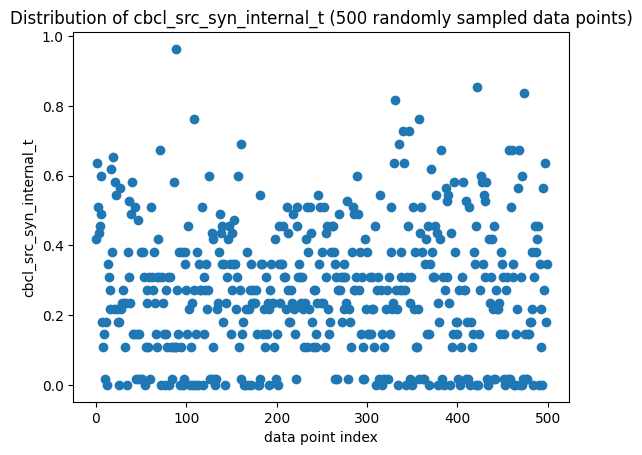

In [7]:
import matplotlib.pyplot as plt
y_values = mh_events_df[y_column]

num_samples = 500
sampled_y_values = y_values.sample(n=num_samples, random_state=42)

plt.scatter(range(len(sampled_y_values)), sampled_y_values)
plt.xlabel("data point index")
plt.ylabel("cbcl_src_syn_internal_t")
plt.title("Distribution of cbcl_src_syn_internal_t (500 randomly sampled data points)")
plt.show()

In [8]:
%pip install scikit-learn
import pandas as pd

from abcd.analysis.methods.sklearn_fitting import set_model_preds

Note: you may need to restart the kernel to use updated packages.


## Linear Regression
Assumes linear relationship in the data

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()

In [10]:

sites_events_train, sites_events_id_test, sites_events_ood_test = dict(), dict(), dict()

for site_id in SITES:
    sites_events_train[site_id], sites_events_id_test[site_id], sites_events_ood_test[site_id] = set_model_preds(model, mh_events_df, site_splits, feature_columns, y_column, site_id)

In [11]:
for site_id in SITES:
    mse_train = mean_squared_error(sites_events_train[site_id]['cbcl_scr_syn_internal_t'], sites_events_train[site_id]['cbcl_scr_syn_internal_t_pred'])
    mse_id_test = mean_squared_error(sites_events_id_test[site_id]['cbcl_scr_syn_internal_t'], sites_events_id_test[site_id]['cbcl_scr_syn_internal_t_pred'])
    mse_ood_test = mean_squared_error(sites_events_ood_test[site_id]['cbcl_scr_syn_internal_t'], sites_events_ood_test[site_id]['cbcl_scr_syn_internal_t_pred'])
    print("----------" + site_id + "----------")
    print("mse train", mse_train)
    print("mse id test", mse_id_test)
    print("mse ood test", mse_ood_test)

----------site01----------
mse train 0.035869491571613586
mse id test 0.03666590652131876
mse ood test 0.034111549148325024
----------site02----------
mse train 0.035853300942617114
mse id test 0.03709528865626497
mse ood test 0.03502910279986425
----------site03----------
mse train 0.03573506324979634
mse id test 0.03632862952528087
mse ood test 0.0406314276351966
----------site04----------
mse train 0.03548314328314956
mse id test 0.03549386528745522
mse ood test 0.043193435273635394
----------site05----------
mse train 0.036047096091141144
mse id test 0.03680649212053369
mse ood test 0.03494552628420267
----------site06----------
mse train 0.03632867870928281
mse id test 0.03645974237402353
mse ood test 0.0346961526230009
----------site07----------
mse train 0.035906813075791355
mse id test 0.037374368184624314
mse ood test 0.034556277444845254
----------site08----------
mse train 0.03592831072501802
mse id test 0.03632154482322627
mse ood test 0.03505637904965914
----------site09--

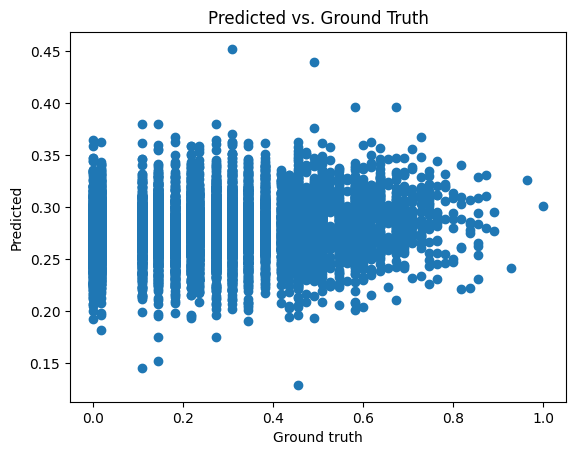

In [12]:
site_id = 'site01'

predicted_values = sites_events_train[site_id]['cbcl_scr_syn_internal_t_pred']
true_values = sites_events_train[site_id]['cbcl_scr_syn_internal_t']

# Calculate the errors for each data point
# errors = [true - pred for true, pred in zip(true_values, predicted_values)]

plt.scatter(true_values, predicted_values)
plt.xlabel("Ground truth")
plt.ylabel("Predicted")
plt.title("Predicted vs. Ground Truth")
plt.show()

## Multi-Layer Perceptron Regressor
Fully connected feed forward neural network

In [13]:
from sklearn.neural_network import MLPRegressor
mlp_model = MLPRegressor(solver='adam', learning_rate_init=0.001, alpha=1e-5, activation='relu', hidden_layer_sizes=(100, 50), max_iter=1000, random_state=1, verbose=True)

In [14]:
sites_events_train_mlp, sites_events_id_test_mlp, sites_events_ood_test_mlp = dict(), dict(), dict()

for site_id in SITES:
    sites_events_train_mlp[site_id], sites_events_id_test_mlp[site_id], sites_events_ood_test_mlp[site_id] = set_model_preds(mlp_model, mh_events_df, site_splits, feature_columns, y_column, site_id)

Iteration 1, loss = 0.03886766
Iteration 2, loss = 0.01914604
Iteration 3, loss = 0.01872166
Iteration 4, loss = 0.01856083
Iteration 5, loss = 0.01848241
Iteration 6, loss = 0.01840716
Iteration 7, loss = 0.01839783
Iteration 8, loss = 0.01834504
Iteration 9, loss = 0.01836154
Iteration 10, loss = 0.01838885
Iteration 11, loss = 0.01884598
Iteration 12, loss = 0.01875722
Iteration 13, loss = 0.01829367
Iteration 14, loss = 0.01889365
Iteration 15, loss = 0.01827274
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.04042111
Iteration 2, loss = 0.01883016
Iteration 3, loss = 0.01868393
Iteration 4, loss = 0.01879201
Iteration 5, loss = 0.01862022
Iteration 6, loss = 0.01849583
Iteration 7, loss = 0.01858077
Iteration 8, loss = 0.01851697
Iteration 9, loss = 0.01838061
Iteration 10, loss = 0.01828774
Iteration 11, loss = 0.01835405
Iteration 12, loss = 0.01832194
Iteration 13, loss = 0.01839642
Iteration 14, loss = 0.01853358


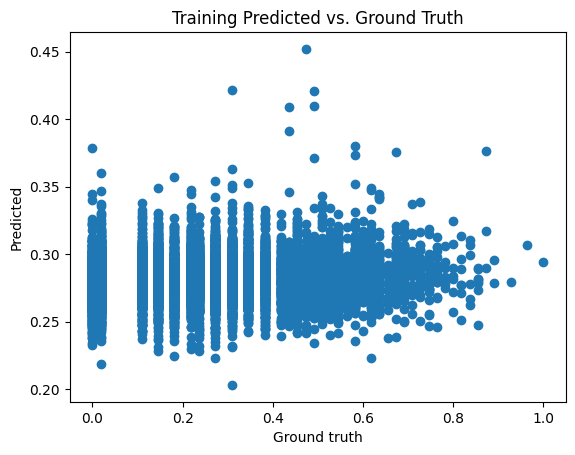

In [15]:
site_id = 'site01'

predicted_values = sites_events_train_mlp[site_id]['cbcl_scr_syn_internal_t_pred']
true_values = sites_events_train_mlp[site_id]['cbcl_scr_syn_internal_t']

# Calculate the errors for each data point
# errors = [true - pred for true, pred in zip(true_values, predicted_values)]

plt.scatter(true_values, predicted_values)
plt.xlabel("Ground truth")
plt.ylabel("Predicted")
plt.title("Training Predicted vs. Ground Truth")
plt.show()

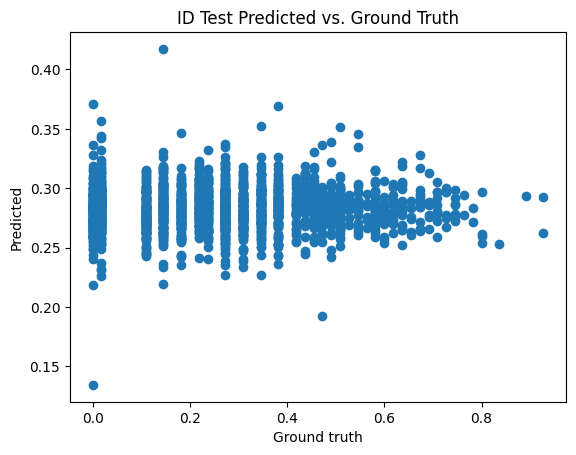

In [16]:
site_id = 'site01'

predicted_values = sites_events_id_test_mlp[site_id]['cbcl_scr_syn_internal_t_pred']
true_values = sites_events_id_test_mlp[site_id]['cbcl_scr_syn_internal_t']

# Calculate the errors for each data point
# errors = [true - pred for true, pred in zip(true_values, predicted_values)]

plt.scatter(true_values, predicted_values)
plt.xlabel("Ground truth")
plt.ylabel("Predicted")
plt.title("ID Test Predicted vs. Ground Truth")
plt.show()

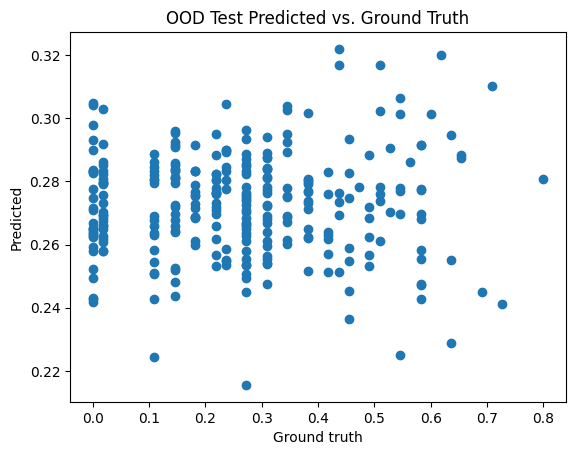

In [17]:
site_id = 'site01'

predicted_values = sites_events_ood_test_mlp[site_id]['cbcl_scr_syn_internal_t_pred']
true_values = sites_events_ood_test_mlp[site_id]['cbcl_scr_syn_internal_t']

# Calculate the errors for each data point
# errors = [true - pred for true, pred in zip(true_values, predicted_values)]

plt.scatter(true_values, predicted_values)
plt.xlabel("Ground truth")
plt.ylabel("Predicted")
plt.title("OOD Test Predicted vs. Ground Truth")
plt.show()

## MLP Grid Search

In [18]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [19]:
from abcd.data.divide_with_splits import divide_events_by_splits

#start with just site01
SITE_ID = 'site01'
events_train, events_id_test, events_ood_test = divide_events_by_splits(mh_events_df, site_splits, SITE_ID)
X_train, X_id_test, X_ood_test = events_train[feature_columns], events_id_test[feature_columns], events_ood_test[feature_columns]
y_train = events_train[y_column]
y_id_test = events_id_test[y_column]
y_ood_test = events_ood_test[y_column]

# Define the parameter grid for the hyperparameter search
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (50, 50), (100, 50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'learning_rate': ['adaptive', 'constant'],
    'alpha': [0, 1e-3, 1e-5]
}

# Define model
mlp_grid_model = MLPRegressor(random_state=1, max_iter=1000, verbose=True)

# Perform the grid search
#cv = cross validation splitting strategy
grid_search = GridSearchCV(mlp_grid_model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

Iteration 1, loss = 0.02874769
Iteration 2, loss = 0.01977702
Iteration 3, loss = 0.01919510
Iteration 4, loss = 0.01932705
Iteration 5, loss = 0.01922210
Iteration 6, loss = 0.01922457
Iteration 7, loss = 0.01878363
Iteration 8, loss = 0.01883513
Iteration 9, loss = 0.01876279
Iteration 10, loss = 0.01910898
Iteration 11, loss = 0.01894844
Iteration 12, loss = 0.01866373
Iteration 13, loss = 0.01899618
Iteration 14, loss = 0.01872734
Iteration 15, loss = 0.01851988
Iteration 16, loss = 0.01871161
Iteration 17, loss = 0.01843104
Iteration 18, loss = 0.01930974
Iteration 19, loss = 0.01841980
Iteration 20, loss = 0.01890682
Iteration 21, loss = 0.01872823
Iteration 22, loss = 0.01875512
Iteration 23, loss = 0.01876928
Iteration 24, loss = 0.01843992
Iteration 25, loss = 0.01851568
Iteration 26, loss = 0.01881674
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.02676883
Iteration 2, loss = 0.01957033
Iteration 3, loss = 0.019

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: Runt

Iteration 1, loss = 14829590755772614304785480836786005141222764030489036892258305048576.00000000
Iteration 2, loss = 13336620943359527952688151837186009081145385589515042151213774640457426822875006477084728039959338313558259469035065879903741618740396375932928.00000000
Iteration 3, loss = 11993955943633230649861526890962361685473873803487784854005161927576995074226369713167330396038201385164039666723504688898987639541785877521797255282573953653439719621449409425255372763998440388663099103870281238708224.00000000
Iteration 4, loss = 10786463811843266503817435792162268833585128501649389767705553087087354457119392666458815685073737720540670519242756950222444706197716729795058926179490512244757037180025487170932584090850529044578893124843586053502905096603838775949497556969384727619830542323252313066681124854182879099355136.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11,

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: Runt

Iteration 4, loss = 11076981872894831318504115281539144090812275017193784688872122907037186673909931445992665142061202719625612067862934530742070958768397178056004268247926629932543900221697666225180251383400586450847560388462525436123309988369830447677217255813147153148716662676526908599482820630595055151742976.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iterati

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: Runt

Iteration 2, loss = 13980415481130520452780083358132179636066621824995931891163360311483518234616125038946668681804867903522130876761559015387079646511550877925376.00000000
Iteration 3, loss = 12572936433186848460234981609396513876825317637986247530309040671364545201592939461685984504390670240976740254983303212110264743662183981823666755338773659081303429485300506205996363093837885326403848366790523846918144.00000000
Iteration 4, loss = 11307155410818528381195819520121301467256529914090994119924998843039485850517394335605568364056762908139658200548384446807478231659076187747494322932477963134333816662116511811326542401937488721048861108142484740657140102376471451202070403429489033621652616964828265147028856786043428220698624.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 1

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: Runt

Iteration 2, loss = 13263318890584655382620798982841961520624414607752602203443310887779750876309376897469925480325066919260846594669652805840591232160122189905920.00000000
Iteration 3, loss = 11928033578793784580397105331768254735195324169053623560795373825116492038218611702959483347508230577022834331227102949530170907393080908363241527082782710654880860256705427250548733091217542952381501919318563774005248.00000000
Iteration 4, loss = 10727178184476354264232558376689779072501770305155305062846410728918657569066307446047806532956268847123715194763397119348802920127662518730721343124916215999014531472992014075089464563470649887603065818684885494989815665584173029725399674679385785315977974998813911191064339596565664799653888.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 1

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.02079890
Iteration 5, loss = 0.02062708
Iteration 6, loss = 0.02050285
Iteration 7, loss = 0.01961981
Iteration 8, loss = 0.01952155
Iteration 9, loss = 0.01944363
Iteration 10, loss = 0.01956948
Iteration 11, loss = 0.01931104
Iteration 12, loss = 0.01902285
Iteration 13, loss = 0.01944163
Iteration 14, loss = 0.01892825
Iteration 15, loss = 0.01952488
Iteration 16, loss = 0.01936268
Iteration 17, loss = 0.01897286
Iteration 18, loss = 0.01899137
Iteration 19, loss = 0.01944809
Iteration 20, loss = 0.01861188
Iteration 21, loss = 0.01871218
Iteration 22, loss = 0.01881695
Iteration 23, loss = 0.01883414
Iteration 24, loss = 0.01858344
Iteration 25, loss = 0.01856322
Iteration 26, loss = 0.01845176
Iteration 27, loss = 0.01940682
Iteration 28, loss = 0.01837092
Iteration 29, loss = 0.01875216
Iteration 30, loss = 0.01877131
Iteration 31, loss = 0.01867269
Iteration 32, loss = 0.01882349
Iteration 33, loss = 0.01860934
Iteration 34, loss = 0.01930719
Iteration 35, 

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: Runt

Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Itera

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: Runt

Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Itera

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: Runt

Iteration 2, loss = 13980415481130520452780083358132179636066621824995931891163360311483518234616125038946668681804867903522130876761559015387079646511550877925376.00000000
Iteration 3, loss = 12572936433186848460234981609396513876825317637986247530309040671364545201592939461685984504390670240976740254983303212110264743662183981823666755338773659081303429485300506205996363093837885326403848366790523846918144.00000000
Iteration 4, loss = 11307155410818528381195819520121301467256529914090994119924998843039485850517394335605568364056762908139658200548384446807478231659076187747494322932477963134333816662116511811326542401937488721048861108142484740657140102376471451202070403429489033621652616964828265147028856786043428220698624.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 1

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: Runt

Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.01883561
Iteration 4, loss = 0.01863035
Iteration 5, loss = 0.01854717
Iteration 6, loss = 0.01855409
Iteration 7, loss = 0.01865243
Iteration 8, loss = 0.01865351
Iteration 9, loss = 0.01848403
Iteration 10, loss = 0.01836290
Iteration 11, loss = 0.01846264
Iteration 12, loss = 0.01836156
Iteration 13, loss = 0.01826464
Iteration 14, loss = 0.01845542
Iteration 15, loss = 0.01855424
Iteration 16, loss = 0.01845353
Iteration 17, loss = 0.01840705
Iteration 18, loss = 0.01849173
Iteration 19, loss = 0.01828573
Iteration 20, loss = 0.01818021
Iteration 21, loss = 0.01822395
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.08229935
Iteration 2, loss = 0.02061314
Iteration 3, loss = 0.01886355
Iteration 4, loss = 0.01856277
Iteration 5, loss = 0.01841523
Iteration 6, loss = 0.01836528
Iteration 7, loss = 0.01844007
Iteration 8, loss = 0.01843739
Iteration 9, loss = 0.01830341
Iteration 10, loss = 0.0182567

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 595181277095862969668540547244307623309702370853550056907200668118304301879669405821011062242705632181562113164089227358675122442839151094968288756881162240.00000000
Iteration 4, loss = 5293333762243289375608734605890475064498175909559458006729236053503171120280562838206711918453398728488820417859628769710087426612626467757351093776512164336222356191444881332847069490712328912246839816430288896.00000000
Iteration 5, loss = 47077056010943430990632989679210203863664930760502377446279781478498693441649976791114884459727470372720762428661349309260025825219393139590586426111863948113711802037563362529361396665745981391751966223536074652800509016110006079153536019623586809673851250537398272.00000000
Iteration 6, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 1191138701856876206358723930920326497481378149587349812381225184100102655543878707867807188325577046078249107486768240330880703814215656164404938435752624128.00000000
Iteration 4, loss = 10593570309905500109974626558626236477096487659002271218137646929945339288289767816285233534310263291682923524053162117434801500296480411073298505119422694541074534872605349684765797820373624035554958030787313664.00000000
Iteration 5, loss = 94215502977076601679432348809848999915610628657155796100542210952049131030866156743568081090803617711730298820032962094387323621630186812270419626241049578056750434702220406974213062661265510879292446116195993045948473214116540667861512686893682342166497847450533888.00000000
Iteration 6, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 475950602163817942032757170265394842941108282217624344937478028714906910788462666064762345466016549941398821268317538869834952555384128548466452789897708744721732380458889355669123096749515607871090171529543041632003195454363570496469651740089452827292287122356043776.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 5237245220701986311408802747842281642500478702285926068561605668059821947312382436040154932605355701553616097152418867366888296286339598566799023420304162677410578001235582904984671128005162963427799034465615872.00000000
Iteration 5, loss = 46578224172573904324096038153951181655526872540059994078283384719656519843941901706521859368553705551935452626560424707352755621298126224042134594572408118735933232062343194148817133962822902728126249180863012006508718884956222217688375200827703472545158295862640640.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.08142784
Iteration 2, loss = 0.02054947
Iteration 3, loss = 0.01883561
Iteration 4, loss = 0.01863035
Iteration 5, loss = 0.01854717
Iteration 6, loss = 0.01855409
Iteration 7, loss = 0.01865243
Iteration 8, loss = 0.01865351
Iteration 9, loss = 0.01848403
Iteration 10, loss = 0.01836290
Iteration 11, loss = 0.01846264
Iteration 12, loss = 0.01836156
Iteration 13, loss = 0.01826464
Iteration 14, loss = 0.01845542
Iteration 15, loss = 0.01855424
Iteration 16, loss = 0.01845353
Iteration 17, loss = 0.01840705
Iteration 18, loss = 0.01849173
Iteration 19, loss = 0.01828573
Iteration 20, loss = 0.01818021
Iteration 21, loss = 0.01822395
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.08229935
Iteration 2, loss = 0.02061314
Iteration 3, loss = 0.01886355
Iteration 4, loss = 0.01856277
Iteration 5, loss = 0.01841523
Iteration 6, loss = 0.01836528
Iteration 7, loss = 0.01844007
Iteration 8, loss = 0.01843739

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 66922051114968269045046276407750120445620395313611410759306694658214658803145812777552846413918896128.00000000
Iteration 3, loss = 595181277095862969668540547244307623309702370853550056907200668118304301879669405821011062242705632181562113164089227358675122442839151094968288756881162240.00000000
Iteration 4, loss = 5293333762243289375608734605890475064498175909559458006729236053503171120280562838206711918453398728488820417859628769710087426612626467757351093776512164336222356191444881332847069490712328912246839816430288896.00000000
Iteration 5, loss = 47077056010943430990632989679210203863664930760502377446279781478498693441649976791114884459727470372720762428661349309260025825219393139590586426111863948113711802037563362529361396665745981391751966223536074652800509016110006079153536019623586809673851250537398272.00000000
Iteration 6, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 15059213847285977443044947527845391841007501312.00000000
Iteration 2, loss = 133931372101685222119499987252157396877433513627427475703465177613515388920035001470472056690326896640.00000000
Iteration 3, loss = 1191138701856876206358723930920326497481378149587349812381225184100102655543878707867807188325577046078249107486768240330880703814215656164404938435752624128.00000000
Iteration 4, loss = 10593570309905500109974626558626236477096487659002271218137646929945339288289767816285233534310263291682923524053162117434801500296480411073298505119422694541074534872605349684765797820373624035554958030787313664.00000000
Iteration 5, loss = 94215502977076601679432348809848999915610628657155796100542210952049131030866156743568081090803617711730298820032962094387323621630186812270419626241049578056750434702220406974213062661265510879292446116195993045948473214116540667861512686893682342166497847450533888.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 676584162756502376310787002134362049715606325232169392050953693351418725537137964972998554113846280192.00000000
Iteration 3, loss = 6017302508562385131118154303264007569223139088869957977279610805889696423108576909725540637383858048845718637212743218089969831834335468459918935494416662528.00000000
Iteration 4, loss = 53515780404960622060865532454331440227719051258317072194676243437624636271666776815059137362513963482638795166368729761985053924233748682103071191034682397641809282488398956678804860799906705621310982011815460864.00000000
Iteration 5, loss = 475950602163817942032757170265394842941108282217624344937478028714906910788462666064762345466016549941398821268317538869834952555384128548466452789897708744721732380458889355669123096749515607871090171529543041632003195454363570496469651740089452827292287122356043776.00000000
Iteration 6, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 7444968357408454792288085494265919291049115648.00000000
Iteration 2, loss = 66212940295087319165277870838717250376921145419808252774788561118793137022448780244121874912006635520.00000000
Iteration 3, loss = 588874693894260176608258049749744410671964038703411718849997244958720124184482480162903562534910455458714725041435585162885554370386813523931284289064271872.00000000
Iteration 4, loss = 5237245220701986311408802747842281642500478702285926068561605668059821947312382436040154932605355701553616097152418867366888296286339598566799023420304162677410578001235582904984671128005162963427799034465615872.00000000
Iteration 5, loss = 46578224172573904324096038153951181655526872540059994078283384719656519843941901706521859368553705551935452626560424707352755621298126224042134594572408118735933232062343194148817133962822902728126249180863012006508718884956222217688375200827703472545158295862640640.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = na

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.01902737
Iteration 5, loss = 0.01880456
Iteration 6, loss = 0.01888341
Iteration 7, loss = 0.01854747
Iteration 8, loss = 0.01843727
Iteration 9, loss = 0.01866471
Iteration 10, loss = 0.01864081
Iteration 11, loss = 0.01860378
Iteration 12, loss = 0.01839706
Iteration 13, loss = 0.01830855
Iteration 14, loss = 0.01834611
Iteration 15, loss = 0.01853548
Iteration 16, loss = 0.01833378
Iteration 17, loss = 0.01834658
Iteration 18, loss = 0.01821579
Iteration 19, loss = 0.01868159
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.04840073
Iteration 2, loss = 0.02047237
Iteration 3, loss = 0.01890453
Iteration 4, loss = 0.01876581
Iteration 5, loss = 0.01849421
Iteration 6, loss = 0.01858905
Iteration 7, loss = 0.01852766
Iteration 8, loss = 0.01829426
Iteration 9, loss = 0.01838938
Iteration 10, loss = 0.01841667
Iteration 11, loss = 0.01859340
Iteration 12, loss = 0.01845530
Iteration 13, loss = 0.018141

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan
Iteration 50, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2


Iteration 3, loss = 14803219951771679863619533143238318581029271559437299409806199798908395715729738861329085907174252201564855418042762086300267143262559963998539622771589120.00000000
Iteration 4, loss = 131654652080079552906836383445904803875077954407196263737045236655726526347958133453908325125148769874554780836429094360129574166261708247606049447557502086306941602046325323372201105151541482147629562222084096.00000000
Iteration 5, loss = 1170890351612476006524760610333982073196542399239662312333674180797854603231745803992305076256550830502757329876938302204658086798314374590294130629736154418563380754214866131654622054243221969834944793028560687717466282623174784882812322191867452136058299938242560.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 15440607822902437424511324540657031234715648.00000000
Iteration 2, loss = 137323356502979562492603486390243628158091647765969381031124951803185263731734030123122671063400448.00000000
Iteration 3, loss = 1221305822771614036764999119421833832317827483450016508915396102936837960622303554982265935130715525826173142995798968641140077061858426748465367060840448.00000000
Iteration 4, loss = 10861866114549373749957032138675540063062976550553672557384715957831932437285654018372171863482781470430798617269522314315773498796794761357755977010470952362632017377987892639998997472196650385040840224407552.00000000
Iteration 5, loss = 96601631868621535916115802374070583673984841788136606572198320502553744463878147057110644755357054651554717472156774498487906357522617939247878738127832361861762399169838621242514973473138197602438805911933137167407491422820739780698299148233344579289387263590400.00000000
Iteration 6, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2247168796924728493507215599445856976109568.00000000
Iteration 2, loss = 19985532005078010772641000365191814658627763226057670477699798124458383516236700499612530051645440.00000000
Iteration 3, loss = 177744319907161206409535512266576244544199336419216246965393621836701033067844933201868248454381056134254357591944096772761774188495881035226134429564928.00000000
Iteration 4, loss = 1580795710178364040186637818362826298314456022265569811462758303348700857373086226291186358097549514038844155687489491584428299387333983705457392715956417510335052387259661334226188521144676935726508346966016.00000000
Iteration 5, loss = 14059043229192560859950115512166529026510316711645360311478216047556884168379305821310870881992681174071138252190787877373654240366430172419165473820710934273065017301220236299107267620510454400517556751525368415033550006657991835168686412129461719752790943727616.00000000
Iteration 6, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: Runt

Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.02021755
Iteration 3, loss = 0.01901552
Iteration 4, loss = 0.01902737
Iteration 5, loss = 0.01880456
Iteration 6, loss = 0.01888341
Iteration 7, loss = 0.01854747
Iteration 8, loss = 0.01843727
Iteration 9, loss = 0.01866471
Iteration 10, loss = 0.01864081
Iteration 11, loss = 0.01860378
Iteration 12, loss = 0.01839706
Iteration 13, loss = 0.01830855
Iteration 14, loss = 0.01834611
Iteration 15, loss = 0.01853548
Iteration 16, loss = 0.01833378
Iteration 17, loss = 0.01834658
Iteration 18, loss = 0.01821579
Iteration 19, loss = 0.01868159
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.04840073
Iteration 2, loss = 0.02047237
Iteration 3, loss = 0.01890453
Iteration 4, loss = 0.01876581
Iteration 5, loss = 0.01849421
Iteration 6, loss = 0.01858905
Iteration 7, loss = 0.01852766
Iteration 8, loss = 0.01829426
Iteration 9, loss = 0.01838938
Iteration 10, loss = 0.01841667
Iteration 11, loss = 0.01859340

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan
Iteration 50, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 187152725819930995222549179921414889073016832.00000000
Iteration 2, loss = 1664470776218766465427965271833573298837355218806797483594201846984677024057769508112371412247773184.00000000
Iteration 3, loss = 14803219951771679863619533143238318581029271559437299409806199798908395715729738861329085907174252201564855418042762086300267143262559963998539622771589120.00000000
Iteration 4, loss = 131654652080079552906836383445904803875077954407196263737045236655726526347958133453908325125148769874554780836429094360129574166261708247606049447557502086306941602046325323372201105151541482147629562222084096.00000000
Iteration 5, loss = 1170890351612476006524760610333982073196542399239662312333674180797854603231745803992305076256550830502757329876938302204658086798314374590294130629736154418563380754214866131654622054243221969834944793028560687717466282623174784882812322191867452136058299938242560.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 15440607822902437424511324540657031234715648.00000000
Iteration 2, loss = 137323356502979562492603486390243628158091647765969381031124951803185263731734030123122671063400448.00000000
Iteration 3, loss = 1221305822771614036764999119421833832317827483450016508915396102936837960622303554982265935130715525826173142995798968641140077061858426748465367060840448.00000000
Iteration 4, loss = 10861866114549373749957032138675540063062976550553672557384715957831932437285654018372171863482781470430798617269522314315773498796794761357755977010470952362632017377987892639998997472196650385040840224407552.00000000
Iteration 5, loss = 96601631868621535916115802374070583673984841788136606572198320502553744463878147057110644755357054651554717472156774498487906357522617939247878738127832361861762399169838621242514973473138197602438805911933137167407491422820739780698299148233344579289387263590400.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: Runt

Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: Runt

Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.09049838
Iteration 2, loss = 0.02044107
Iteration 3, loss = 0.01873085
Iteration 4, loss = 0.01851108
Iteration 5, loss = 0.01848389
Iteration 6, loss = 0.01845026
Iteration 7, loss = 0.01838857
Iteration 8, loss = 0.01833830
Iteration 9, loss = 0.01833593
Iteration 10, loss = 0.01855093
Iteration 11, loss = 0.01849246
Iteration 12, loss = 0.01835557
Iteration 13, loss = 0.01850061
Iteration 14, loss = 0.01836433
Iteration 15, loss = 0.01844723
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.09105503
Iteration 2, loss = 0.02014932
Iteration 3, loss = 0.01844804
Iteration 4, loss = 0.01836231
Iteration 5, loss = 0.01835553
Iteration 6, loss = 0.01830280
Iteration 7, loss = 0.01819142
Iteration 8, loss = 0.01809936
Iteration 9, loss = 0.01813041
Iteration 10, loss = 0.01812979
Iteration 11, loss = 0.01821965
Iteration 12, loss = 0.01812162
Iteration 13, loss = 0.01832667
Iteration 14, loss = 0.01815947


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 302681850400744564857522459096184047780177163850189780525545754792771786966403221120196765379040642332869543102544873515656234050592513031462388497475698688.00000000
Iteration 4, loss = 2691946335681850596910264783335616189096853421414435571917162965556924440284187164295606700430809299006613221858322752439751622664343085141910236838219377663226588200374448136571949402692103371381398452039581696.00000000
Iteration 5, loss = 23941227611093012342516868965794211681037729158811036759474758048597241136555417982717473437219993749188373067708058801483309289580694793864149334275132460039845482464352746705514238413203624608935661400470760565711503354477453394858420332006892879770023370109747200.00000000
Iteration 6, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 6004385764089854425666358431506439561352807609156802700450407476172762580490942548073406996311703552.00000000
Iteration 3, loss = 53400903404885461419780479344478417462860000384933747979220509156239990948549712818535956229049733944771435436771697257124124278296174479752699922299748352.00000000
Iteration 4, loss = 474928926371227095880043497785950785008677223450572388167364797662726606101363182177517321508671449482811794866997733675409427259709174929761925590469106400072385174698205521707695833091277945590452520174485504.00000000
Iteration 5, loss = 4223851484195674332061292180583563582618581083019495681998941111979125247262534975962347238585779400728526907132666518362706108445198663428578822006992935867601497975584277992864336865554918292645183107390461826358423504465939054467010547910109927761565847893573632.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 2230304862813233444353236671028215837870186995904692706623777825980939319342456908103285244532886784764762102373050324457720184683507930045679333731653910528.00000000
Iteration 4, loss = 19835550083211334839567855171200565523459441964420178056687177010887628502922650832255511352332364920444586694435250160262175112962649580553598955024443948323897997278555442166462659601990740315689063496816787456.00000000
Iteration 5, loss = 176410433238859092488053658113654975314300374866221313315415339044955668464301066681597937624923499249134122539133592509448000965422865031746530852732134848498150031125251181010552505111703980851455249575424228374194397423068023520481579916512085894647001164808192000.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 25439086240175303936546575445753379515925528576.00000000
Iteration 2, loss = 226246320671907101475462262827845555187538527958362912554350805757048721208986498184320232537225953280.00000000
Iteration 3, loss = 2012155512753309828472461168008729964180202783449981730879264228241229281485187417010696144272770873924177916635766696924967393664151244056192081199137554432.00000000
Iteration 4, loss = 17895406190383664884345566202811914756561410298662213863593172208526971746183696342173082941422943620144246720797135274918844804179070146019003488002034871549319913825935086020097868295838284621483408364289392640.00000000
Iteration 5, loss = 159155473167490326833143926564574377556187184713137912427336781953557993328035449729429931052569899174762683468115148845575663446021150846312579826036670904715922973275260954903488915844704229054940119536367315497905692726039999910119264249497868085941093199425568768.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.01873085
Iteration 4, loss = 0.01851108
Iteration 5, loss = 0.01848389
Iteration 6, loss = 0.01845026
Iteration 7, loss = 0.01838857
Iteration 8, loss = 0.01833830
Iteration 9, loss = 0.01833593
Iteration 10, loss = 0.01855093
Iteration 11, loss = 0.01849246
Iteration 12, loss = 0.01835557
Iteration 13, loss = 0.01850061
Iteration 14, loss = 0.01836433
Iteration 15, loss = 0.01844723
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.09105503
Iteration 2, loss = 0.02014932
Iteration 3, loss = 0.01844804
Iteration 4, loss = 0.01836231
Iteration 5, loss = 0.01835553
Iteration 6, loss = 0.01830280
Iteration 7, loss = 0.01819142
Iteration 8, loss = 0.01809936
Iteration 9, loss = 0.01813041
Iteration 10, loss = 0.01812979
Iteration 11, loss = 0.01821965
Iteration 12, loss = 0.01812162
Iteration 13, loss = 0.01832667
Iteration 14, loss = 0.01815947
Iteration 15, loss = 0.01814034
Iteration 16, loss = 0.0186207

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 2691946335681850596910264783335616189096853421414435571917162965556924440284187164295606700430809299006613221858322752439751622664343085141910236838219377663226588200374448136571949402692103371381398452039581696.00000000
Iteration 5, loss = 23941227611093012342516868965794211681037729158811036759474758048597241136555417982717473437219993749188373067708058801483309289580694793864149334275132460039845482464352746705514238413203624608935661400470760565711503354477453394858420332006892879770023370109747200.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 6004385764089854425666358431506439561352807609156802700450407476172762580490942548073406996311703552.00000000
Iteration 3, loss = 53400903404885461419780479344478417462860000384933747979220509156239990948549712818535956229049733944771435436771697257124124278296174479752699922299748352.00000000
Iteration 4, loss = 474928926371227095880043497785950785008677223450572388167364797662726606101363182177517321508671449482811794866997733675409427259709174929761925590469106400072385174698205521707695833091277945590452520174485504.00000000
Iteration 5, loss = 4223851484195674332061292180583563582618581083019495681998941111979125247262534975962347238585779400728526907132666518362706108445198663428578822006992935867601497975584277992864336865554918292645183107390461826358423504465939054467010547910109927761565847893573632.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 250774985327895779840817499920678195440807147051165629226017545373410498612918188274452185327654141952.00000000
Iteration 3, loss = 2230304862813233444353236671028215837870186995904692706623777825980939319342456908103285244532886784764762102373050324457720184683507930045679333731653910528.00000000
Iteration 4, loss = 19835550083211334839567855171200565523459441964420178056687177010887628502922650832255511352332364920444586694435250160262175112962649580553598955024443948323897997278555442166462659601990740315689063496816787456.00000000
Iteration 5, loss = 176410433238859092488053658113654975314300374866221313315415339044955668464301066681597937624923499249134122539133592509448000965422865031746530852732134848498150031125251181010552505111703980851455249575424228374194397423068023520481579916512085894647001164808192000.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 226246320671907101475462262827845555187538527958362912554350805757048721208986498184320232537225953280.00000000
Iteration 3, loss = 2012155512753309828472461168008729964180202783449981730879264228241229281485187417010696144272770873924177916635766696924967393664151244056192081199137554432.00000000
Iteration 4, loss = 17895406190383664884345566202811914756561410298662213863593172208526971746183696342173082941422943620144246720797135274918844804179070146019003488002034871549319913825935086020097868295838284621483408364289392640.00000000
Iteration 5, loss = 159155473167490326833143926564574377556187184713137912427336781953557993328035449729429931052569899174762683468115148845575663446021150846312579826036670904715922973275260954903488915844704229054940119536367315497905692726039999910119264249497868085941093199425568768.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:339: RuntimeWarning: invalid value encountered in scalar multiply
  loss += (0.5 * self.alpha) * values / n_samples
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.06063144
Iteration 2, loss = 0.02290833
Iteration 3, loss = 0.02138678
Iteration 4, loss = 0.02112405
Iteration 5, loss = 0.02095208
Iteration 6, loss = 0.02082779
Iteration 7, loss = 0.01994460
Iteration 8, loss = 0.01984619
Iteration 9, loss = 0.01976820
Iteration 10, loss = 0.01989397
Iteration 11, loss = 0.01963531
Iteration 12, loss = 0.01934717
Iteration 13, loss = 0.01976609
Iteration 14, loss = 0.01925237
Iteration 15, loss = 0.01984958
Iteration 16, loss = 0.01968697
Iteration 17, loss = 0.01929667
Iteration 18, loss = 0.01931545
Iteration 19, loss = 0.01977239
Iteration 20, loss = 0.01893603
Iteration 21, loss = 0.01903558
Iteration 22, loss = 0.01914022
Iteration 23, loss = 0.01915736
Iteration 24, loss = 0.01890610
Iteration 25, loss = 0.01888733
Iteration 26, loss = 0.01877641
Iteration 27, loss = 0.01973275
Iteration 28, loss = 0.01869535
Iteration 29, loss = 0.01907469
Iteration 30, loss = 0.01909456
Iteration 31, loss = 0.01899627
Iteration 32, los

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Itera

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 13336617744041691550708590974230587904194718427348496809756877375195250715394200789826022737910263003311293446966244013321084058821299930136576.00000000
Iteration 3, loss = 11993992574330911572023626500807516019791485974609259394041912077435119754918856855378849233892693363140774076696489689765652564089581515087090173889458845557219213091958498702188983139258053833389425790464526152368128.00000000
Iteration 4, loss = 10786532285321500548342888550361052759421477590188976302402328489243079197978787946250415443321769959771311036216553115490626707623983965495387878869549723501101899181159364349671456832483440411521643442627288541700131560470748209129006064330171970155792110609798028480088342708885817214894080.00000000
Iteration 5, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 15228953453146608178743498304245522187246491753448799553292616073216.00000000
Iteration 2, loss = 13695822863780011712009339906394486637943262004536477599381457729835254333225922513637728541660394525345868324235173418019184211155254220161024.00000000
Iteration 3, loss = 12317035736770998302790546071219595858105153204380363237027022854590803563349008673836446968277583076344833942874457451484643756691850435658937972328411639626170759193867900145711716567061946347909203497184387596812288.00000000
Iteration 4, loss = 11077053993017949710330755810600698982427880332623649740859732855627215108204955448738678760336679170282462763642726990196513988659197914912497982261037713715922444560934251448152711946425046316084389306458923341873914621661310743299625086427750995811367949423481649433884734387057589030486016.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Itera

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 15545443640152974699765024669621568031294013415972173028200013627392.00000000
Iteration 2, loss = 13980451321848521526286247470354812309556192802219740721507427553159945177567062042766745375286185225299124386267880918131389239051008337772544.00000000
Iteration 3, loss = 12573010052779984934030409469448985157745976993586870650073791791035981146829680370534122176495620436370260703138316007512636739797195323473894763830343405307218290172406955967493653995864611438430679424354785744125952.00000000
Iteration 4, loss = 11307258839366405698802011263344599012835901459053642498303652830838846064359180592335240070406297233437798827482415063536285741756949527827758577766921145799165578499943831300866789933183323748449674100526218268741095274956555818328213803068762618838266520558366418640800923064282066689458176.00000000
Iteration 5, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 10727260854402128049453409942862217595724537808076831074975421053326720615931686279117023322230260846758537875531645876194085531932785498820243620310857191315371781736414394404926459251859531648964026549229591543197712817669194146819118309457121862608213471182930038543081350538075333667586048.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.06063144
Iteration 2, loss = 0.02290833
Iteration 3, loss = 0.02138678
Iteration 4, loss = 0.02112405
Iteration 5, loss = 0.02095208
Iteration 6, loss = 0.02082779
Iteration 7, loss = 0.01994460
Iteration 8, loss = 0.01984619
Iteration 9, loss = 0.01976820
Iteration 10, loss = 0.01989397
Iteration 11, loss = 0.01963531
Iteration 12, loss = 0.01934717
Iteration 13, loss = 0.01976609
Iteration 14, loss = 0.01925237
Iteration 15, loss = 0.01984958
Iteration 16, loss = 0.01968697
Iteration 17, loss = 0.01929667
Iteration 18, loss = 0.01931545
Iteration 19, loss = 0.01977239
Iteration 20, loss = 0.01893603
Iteration 21, loss = 0.01903558
Iteration 22, loss = 0.01914022
Iteration 23, loss = 0.01915736
Iteration 24, loss = 0.01890610
Iteration 25, loss = 0.01888733
Iteration 26, loss = 0.01877641
Iteration 27, loss = 0.01973275
Iteration 28, loss = 0.01869535
Iteration 29, loss = 0.01907469
Iteration 30, loss = 0.01909456
Iteration 31, loss = 0.01899627
Iteration 32, los

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z*

Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z*

Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z*

Iteration 4, loss = 11307258839366405698802011263344599012835901459053642498303652830838846064359180592335240070406297233437798827482415063536285741756949527827758577766921145799165578499943831300866789933183323748449674100526218268741095274956555818328213803068762618838266520558366418640800923064282066689458176.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iterati

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z*

Iteration 1, loss = 14748050910866280450462530943050761298075906343824106178479271182336.00000000
Iteration 2, loss = 13263333786045710612756969675600564713955922002754709023095168801177654260829154955772042252794902738769514111696082874001576878760906700357632.00000000
Iteration 3, loss = 11928086238869762165759292862300074659845730619740149659206390518087576330883988075559117669805126194751714856651168044950892454752104089470684573016216691428810257207440579207690579314931485242073014797349751617486848.00000000
Iteration 4, loss = 10727260854402128049453409942862217595724537808076831074975421053326720615931686279117023322230260846758537875531645876194085531932785498820243620310857191315371781736414394404926459251859531648964026549229591543197712817669194146819118309457121862608213471182930038543081350538075333667586048.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11,

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.01912374
Iteration 5, loss = 0.01904047
Iteration 6, loss = 0.01904732
Iteration 7, loss = 0.01914557
Iteration 8, loss = 0.01914657
Iteration 9, loss = 0.01897694
Iteration 10, loss = 0.01885572
Iteration 11, loss = 0.01895532
Iteration 12, loss = 0.01885414
Iteration 13, loss = 0.01875701
Iteration 14, loss = 0.01894766
Iteration 15, loss = 0.01904633
Iteration 16, loss = 0.01894546
Iteration 17, loss = 0.01889874
Iteration 18, loss = 0.01898335
Iteration 19, loss = 0.01877717
Iteration 20, loss = 0.01867168
Iteration 21, loss = 0.01871512
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.08279309
Iteration 2, loss = 0.02110670
Iteration 3, loss = 0.01935705
Iteration 4, loss = 0.01905621
Iteration 5, loss = 0.01890860
Iteration 6, loss = 0.01885859
Iteration 7, loss = 0.01893337
Iteration 8, loss = 0.01893053
Iteration 9, loss = 0.01879641
Iteration 10, loss = 0.01874961
Iteration 11, loss = 0.018747

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 47075832183255661554982004675540434249801316799821666817039700130055650699735551403540531255230575743197219214710947289430064800517098349960250659292891231146729903159409354447398500511715763966493434792412045561846540285530942866348065263024081330359965551700213760.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 133944953285105490526217712485047405282169503460151215880130632320101601036782068679488249800043790336.00000000
Iteration 3, loss = 1191267874288626625325912075168074376071403279067395433232642166112256460251081257472654449596454797808737890040568331829614388519460299926626622950344753152.00000000
Iteration 4, loss = 10594793708214834559179667012664633037200680218331887529351372596612190312668223790609692684852444509957807603916009886816932884054814745480289118478131751791939366788936474317531596979931080049582391245978730496.00000000
Iteration 5, loss = 94227046781274481319180803170392774507828885272253188597887655531188186956772846430870306146114494589185025193169699600441594004807979332914082576825227426309736569913995081333164165698462404939801728478036413574507314441577574311660156118279641790849841273052856320.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 76075279567540461541285148963488298254322368512.00000000
Iteration 2, loss = 676591647192831051072382216310850130212264101041598034330494101421454694085743286060175453851796635648.00000000
Iteration 3, loss = 6017411433167307915842822791995450908210457513848402274966932628657023692875947040323551780144320609868872266683355293503026886069889573870674048206216626176.00000000
Iteration 4, loss = 53517125885674343340768730877175120772840743747065728488153345619951266947894257942909837176596992437278754704394084037369980919204741445036050047175326457920212947131660950514660506378565327180616689278039097344.00000000
Iteration 5, loss = 475965919045607429277139366968073413728560192704006761953738852205307108091290766055354426725788785240068986761603450383669037674727566712123271715405866181603784413068653568361111605680153269816190107087609598696070129066993046473009442713827923820532275212802064384.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 5240799861050039562739217061932630168375654525162626869886689424274891087086678937615115360045591727487516046774997566691175412507744125553627803660803876134918303697809478319619515389409194335970626212234002432.00000000
Iteration 5, loss = 46610166019140445888877352175908469827220524313128740915586735142481362873695915697195959595961228639658993947448651950860741376287928107067328966950258824085475946626347889739721221913217189677179896028754859455468881971543448023720286459242305637763560387903488000.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.02104300
Iteration 3, loss = 0.01932907
Iteration 4, loss = 0.01912374
Iteration 5, loss = 0.01904047
Iteration 6, loss = 0.01904732
Iteration 7, loss = 0.01914557
Iteration 8, loss = 0.01914657
Iteration 9, loss = 0.01897694
Iteration 10, loss = 0.01885572
Iteration 11, loss = 0.01895532
Iteration 12, loss = 0.01885414
Iteration 13, loss = 0.01875701
Iteration 14, loss = 0.01894766
Iteration 15, loss = 0.01904633
Iteration 16, loss = 0.01894546
Iteration 17, loss = 0.01889874
Iteration 18, loss = 0.01898335
Iteration 19, loss = 0.01877717
Iteration 20, loss = 0.01867168
Iteration 21, loss = 0.01871512
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.08279309
Iteration 2, loss = 0.02110670
Iteration 3, loss = 0.01935705
Iteration 4, loss = 0.01905621
Iteration 5, loss = 0.01890860
Iteration 6, loss = 0.01885859
Iteration 7, loss = 0.01893337
Iteration 8, loss = 0.01893053
Iteration 9, loss = 0.01879641

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 595157419401227138753576584121148871929016507581974513090419482209194322315877584758774618725945653229297150998462956812812246826437015494802912873132589056.00000000
Iteration 4, loss = 5293158867666178175252267833591202499409298708678328861591426845239040804955508174086544870427965854919982601640406480902406725112829290418872386987118763841554560090903187966127723412610979201518574314587160576.00000000
Iteration 5, loss = 47075832183255661554982004675540434249801316799821666817039700130055650699735551403540531255230575743197219214710947289430064800517098349960250659292891231146729903159409354447398500511715763966493434792412045561846540285530942866348065263024081330359965551700213760.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 133944953285105490526217712485047405282169503460151215880130632320101601036782068679488249800043790336.00000000
Iteration 3, loss = 1191267874288626625325912075168074376071403279067395433232642166112256460251081257472654449596454797808737890040568331829614388519460299926626622950344753152.00000000
Iteration 4, loss = 10594793708214834559179667012664633037200680218331887529351372596612190312668223790609692684852444509957807603916009886816932884054814745480289118478131751791939366788936474317531596979931080049582391245978730496.00000000
Iteration 5, loss = 94227046781274481319180803170392774507828885272253188597887655531188186956772846430870306146114494589185025193169699600441594004807979332914082576825227426309736569913995081333164165698462404939801728478036413574507314441577574311660156118279641790849841273052856320.00000000
Iteration 6, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 676591647192831051072382216310850130212264101041598034330494101421454694085743286060175453851796635648.00000000
Iteration 3, loss = 6017411433167307915842822791995450908210457513848402274966932628657023692875947040323551780144320609868872266683355293503026886069889573870674048206216626176.00000000
Iteration 4, loss = 53517125885674343340768730877175120772840743747065728488153345619951266947894257942909837176596992437278754704394084037369980919204741445036050047175326457920212947131660950514660506378565327180616689278039097344.00000000
Iteration 5, loss = 475965919045607429277139366968073413728560192704006761953738852205307108091290766055354426725788785240068986761603450383669037674727566712123271715405866181603784413068653568361111605680153269816190107087609598696070129066993046473009442713827923820532275212802064384.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 66256947695039561499328666019602056171139004055472311694837003094894294841084664140719466698676109312.00000000
Iteration 3, loss = 589270228565603566528404701124095022345396735324796771662047054602454004336152403829397222709336893185004020021844476780361657753515664742110341308381921280.00000000
Iteration 4, loss = 5240799861050039562739217061932630168375654525162626869886689424274891087086678937615115360045591727487516046774997566691175412507744125553627803660803876134918303697809478319619515389409194335970626212234002432.00000000
Iteration 5, loss = 46610166019140445888877352175908469827220524313128740915586735142481362873695915697195959595961228639658993947448651950860741376287928107067328966950258824085475946626347889739721221913217189677179896028754859455468881971543448023720286459242305637763560387903488000.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.01935244
Iteration 5, loss = 0.01912914
Iteration 6, loss = 0.01920816
Iteration 7, loss = 0.01887227
Iteration 8, loss = 0.01876180
Iteration 9, loss = 0.01898927
Iteration 10, loss = 0.01896499
Iteration 11, loss = 0.01892815
Iteration 12, loss = 0.01872133
Iteration 13, loss = 0.01863275
Iteration 14, loss = 0.01867041
Iteration 15, loss = 0.01885961
Iteration 16, loss = 0.01865751
Iteration 17, loss = 0.01867020
Iteration 18, loss = 0.01853961
Iteration 19, loss = 0.01900559
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.04872543
Iteration 2, loss = 0.02079704
Iteration 3, loss = 0.01922927
Iteration 4, loss = 0.01909061
Iteration 5, loss = 0.01881895
Iteration 6, loss = 0.01891383
Iteration 7, loss = 0.01885232
Iteration 8, loss = 0.01861882
Iteration 9, loss = 0.01871374
Iteration 10, loss = 0.01874094
Iteration 11, loss = 0.01891748
Iteration 12, loss = 0.01877911
Iteration 13, loss = 0.018465

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z*

Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 122599205012171351899460573346789191155111622098181021437826205978923516218854460159773758713757696.00000000
Iteration 3, loss = 1090362053682297901892085588598708987348131509061615998302721813963226968336260140553517733535520945039679846104547381869796693597219180132604123245707264.00000000
Iteration 4, loss = 9697366373559586292679213040786406046621393488756195221665804604988234217268338504172075678253051281775328120099506575114046381008293798184528988189392007676078269239604842024258676688279131078589044882407424.00000000
Iteration 5, loss = 86245586285278955954271317522912080457568037868309740795994898876035139104475847298116537563333195093459439460454453574686917090314542260571594523844058549726536804759080312482480216922568835270841420805901444933239628470299452129032390305429916492853470358929408.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 15098310835227699793916333837351940850685212331573608970202091211989627764996159627380600074141696.00000000
Iteration 3, loss = 134280032303617040393938196059887393795412945355702333003064940493343610753611484498704830068178130812395567226568709358964770414596739541441136499359744.00000000
Iteration 4, loss = 1194247970666381251405054266249376186801217236758407279338310420410936940904135130589798329204809183668426207094358236627978917842368930393195775742807222415808552060172921377356742196928632253528350518149120.00000000
Iteration 5, loss = 10621297827929994469467800435138897401418790368702004313063919938463084487684933049195485088623500411022311776951763947636413019444002277366766903062880542355738891489000079052308659113223875966867408183725802578503495734642758012278765371718829800560641494220800.00000000
Iteration 6, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 242136302068752845816147283373290150949574194995987216004235140683308017129655117792827733931052557429484973216105310968494277917707577641071137840431104.00000000
Iteration 4, loss = 2153490600273632824475578839035736510613389009781567391226352818670714726983091132052141985188006410158485131081726769716255766147569345763471904466002728288862586953648788555976533897569665271656424623046656.00000000
Iteration 5, loss = 19152525771001579786159293116686393071653745100797047119674159548023648296739279497843043019985712020827540693170837752401522819730472363171102604834752320946610157568076502516482990223438568626530382836401413514412399609772117113372690279394148932168534219292672.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.04525658
Iteration 2, loss = 0.02054273
Iteration 3, loss = 0.01934047
Iteration 4, loss = 0.01935244
Iteration 5, loss = 0.01912914
Iteration 6, loss = 0.01920816
Iteration 7, loss = 0.01887227
Iteration 8, loss = 0.01876180
Iteration 9, loss = 0.01898927
Iteration 10, loss = 0.01896499
Iteration 11, loss = 0.01892815
Iteration 12, loss = 0.01872133
Iteration 13, loss = 0.01863275
Iteration 14, loss = 0.01867041
Iteration 15, loss = 0.01885961
Iteration 16, loss = 0.01865751
Iteration 17, loss = 0.01867020
Iteration 18, loss = 0.01853961
Iteration 19, loss = 0.01900559
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.04872543
Iteration 2, loss = 0.02079704
Iteration 3, loss = 0.01922927
Iteration 4, loss = 0.01909061
Iteration 5, loss = 0.01881895
Iteration 6, loss = 0.01891383
Iteration 7, loss = 0.01885232
Iteration 8, loss = 0.01861882
Iteration 9, loss = 0.01871374
Iteration 10, loss = 0.01874094


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan
Iteration 50, loss = nan
Iteration 51, loss = nan
Iteration 52, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 131665838665535433266199572446882028399316094492962979688321430393882468981118939850505628856162120442843408580704909506928362700256682878945617835534586848859916711954767403623748489037226241518116303603236864.00000000
Iteration 5, loss = 1170998090223384866015949628077748540797945365603772737330841511997549744507408933121254154387262023880775755700926301609279539453461771130489978585937019025110173274692732447538774555792929163712629520565802891223782004537314784365912013845481575001078043347255296.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 86245586285278955954271317522912080457568037868309740795994898876035139104475847298116537563333195093459439460454453574686917090314542260571594523844058549726536804759080312482480216922568835270841420805901444933239628470299452129032390305429916492853470358929408.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 15098310835227699793916333837351940850685212331573608970202091211989627764996159627380600074141696.00000000
Iteration 3, loss = 134280032303617040393938196059887393795412945355702333003064940493343610753611484498704830068178130812395567226568709358964770414596739541441136499359744.00000000
Iteration 4, loss = 1194247970666381251405054266249376186801217236758407279338310420410936940904135130589798329204809183668426207094358236627978917842368930393195775742807222415808552060172921377356742196928632253528350518149120.00000000
Iteration 5, loss = 10621297827929994469467800435138897401418790368702004313063919938463084487684933049195485088623500411022311776951763947636413019444002277366766903062880542355738891489000079052308659113223875966867408183725802578503495734642758012278765371718829800560641494220800.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 3415383855282921891539878391485597355701477089878449361092870144.00000000
Iteration 2, loss = 27225560572254938544193334225853331155932888181808188795550680685446067919526276104360579613851648.00000000
Iteration 3, loss = 242136302068752845816147283373290150949574194995987216004235140683308017129655117792827733931052557429484973216105310968494277917707577641071137840431104.00000000
Iteration 4, loss = 2153490600273632824475578839035736510613389009781567391226352818670714726983091132052141985188006410158485131081726769716255766147569345763471904466002728288862586953648788555976533897569665271656424623046656.00000000
Iteration 5, loss = 19152525771001579786159293116686393071653745100797047119674159548023648296739279497843043019985712020827540693170837752401522819730472363171102604834752320946610157568076502516482990223438568626530382836401413514412399609772117113372690279394148932168534219292672.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.09111728
Iteration 2, loss = 0.02105957
Iteration 3, loss = 0.01934941
Iteration 4, loss = 0.01912956
Iteration 5, loss = 0.01910239
Iteration 6, loss = 0.01906865
Iteration 7, loss = 0.01900688
Iteration 8, loss = 0.01895650
Iteration 9, loss = 0.01895413
Iteration 10, loss = 0.01916917
Iteration 11, loss = 0.01911031
Iteration 12, loss = 0.01897311
Iteration 13, loss = 0.01911818
Iteration 14, loss = 0.01898171
Iteration 15, loss = 0.01906501
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.09167404
Iteration 2, loss = 0.02076783
Iteration 3, loss = 0.01906656
Iteration 4, loss = 0.01898079
Iteration 5, loss = 0.01897403
Iteration 6, loss = 0.01892120
Iteration 7, loss = 0.01880966
Iteration 8, loss = 0.01871761
Iteration 9, loss = 0.01874860
Iteration 10, loss = 0.01874789
Iteration 11, loss = 0.01883746
Iteration 12, loss = 0.01873933
Iteration 13, loss = 0.01894427
Iteration 14, loss = 0.01877694


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 3826502512246772162395125778919110564644913152.00000000
Iteration 2, loss = 34031812499660807119427854692987801547248034067776808660619250626587525886459545004679215218836897792.00000000
Iteration 3, loss = 302669149779834564258617222762557291694057625768414315365737006011042790874586414458442037430279716890940138731779008543065544054755714526969418590464245760.00000000
Iteration 4, loss = 2691852343431898564161915005217198847117565069136429403237928478882820891652090861620847864714588922621496337941062991431023665614093165045074142358234878498143137971946391411696954286887338713748834129360715776.00000000
Iteration 5, loss = 23940560325063364595506040242141858073445225926730105916508571180406051179039751194505241001812291996122800818663059162652657624664730482139018013107998974128895296249566645959660695276342622944043501428898828070311308087601823452159321244691799890397908530507022336.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = na

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 6003306087488183931926462126208019729197109728539361588821903924589420292581591088032633605997985792.00000000
Iteration 3, loss = 53391676999759629615059810018347804917448909359342625339596837793142279245469607050610528755455700792477729904231058646828101310924254391303866200960794624.00000000
Iteration 4, loss = 474850212749921021887970619448614827441482001445424625860034740393020310868658514662348871336383837828799720164375108293309431034536944126721690087477910842030086087760243568357057745564120264183310694175735808.00000000
Iteration 5, loss = 4223181162668062992800154046653385364116145174804261234381418670838791387398327854412987918448072259213439724062015224412693125998121319047011243192604530359612033054679543974170967701153728080754532607782277389843149091615499519536449131214673152378069945671483392.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 250775592070003778824711452406245690223114369294244487918576715003524167553975732084714077497736560640.00000000
Iteration 3, loss = 2230325959745787261122643108946061168447893178837038971238680717455082032325203119214449645924712766081394299466968281700911813588842294509571058107982807040.00000000
Iteration 4, loss = 19835877350166932212541175020118198023922181175933276533273718495771959829111314502294807853226072219377630310726250127581834311613385080663487664547669949011513797926139200489233078104833940824918631172318167040.00000000
Iteration 5, loss = 176414585738721179503017127846615439084806314776041883271641825983726904351307682310892179383103124922985887691850067578396997522160175952040009895376374343757463977717093295832488577962025375274368658200413691308908093499896145063664985622627420373835037225124888576.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 2012102156104198266932843811080082780488533986033304930632518177897847929778543714153578774376246081464063274876772414533828248831196921965793167560893530112.00000000
Iteration 4, loss = 17895057630516952886377177289953872394723455637622684860752815683966764376082556363135256926045496992229155310464023421548361145475782841867330455793428347791374681923172250481120934025500498434383187552703086592.00000000
Iteration 5, loss = 159153493587796543673051767744915632439766340761418008097659643904140948632283941902227229038424599505593673959866256428516707643021844148440270907483563260166815769808731056690416494565717831699509669753277347509374864992798145908603276005222057569588051826349965312.00000000
Iteration 6, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.02105957
Iteration 3, loss = 0.01934941
Iteration 4, loss = 0.01912956
Iteration 5, loss = 0.01910239
Iteration 6, loss = 0.01906865
Iteration 7, loss = 0.01900688
Iteration 8, loss = 0.01895650
Iteration 9, loss = 0.01895413
Iteration 10, loss = 0.01916917
Iteration 11, loss = 0.01911031
Iteration 12, loss = 0.01897311
Iteration 13, loss = 0.01911818
Iteration 14, loss = 0.01898171
Iteration 15, loss = 0.01906501
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.09167404
Iteration 2, loss = 0.02076783
Iteration 3, loss = 0.01906656
Iteration 4, loss = 0.01898079
Iteration 5, loss = 0.01897403
Iteration 6, loss = 0.01892120
Iteration 7, loss = 0.01880966
Iteration 8, loss = 0.01871761
Iteration 9, loss = 0.01874860
Iteration 10, loss = 0.01874789
Iteration 11, loss = 0.01883746
Iteration 12, loss = 0.01873933
Iteration 13, loss = 0.01894427
Iteration 14, loss = 0.01877694
Iteration 15, loss = 0.01875802

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 3826502512246772162395125778919110564644913152.00000000
Iteration 2, loss = 34031812499660807119427854692987801547248034067776808660619250626587525886459545004679215218836897792.00000000
Iteration 3, loss = 302669149779834564258617222762557291694057625768414315365737006011042790874586414458442037430279716890940138731779008543065544054755714526969418590464245760.00000000
Iteration 4, loss = 2691852343431898564161915005217198847117565069136429403237928478882820891652090861620847864714588922621496337941062991431023665614093165045074142358234878498143137971946391411696954286887338713748834129360715776.00000000
Iteration 5, loss = 23940560325063364595506040242141858073445225926730105916508571180406051179039751194505241001812291996122800818663059162652657624664730482139018013107998974128895296249566645959660695276342622944043501428898828070311308087601823452159321244691799890397908530507022336.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = na

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 675005656410371190487142891177792914413584384.00000000
Iteration 2, loss = 6003306087488183931926462126208019729197109728539361588821903924589420292581591088032633605997985792.00000000
Iteration 3, loss = 53391676999759629615059810018347804917448909359342625339596837793142279245469607050610528755455700792477729904231058646828101310924254391303866200960794624.00000000
Iteration 4, loss = 474850212749921021887970619448614827441482001445424625860034740393020310868658514662348871336383837828799720164375108293309431034536944126721690087477910842030086087760243568357057745564120264183310694175735808.00000000
Iteration 5, loss = 4223181162668062992800154046653385364116145174804261234381418670838791387398327854412987918448072259213439724062015224412693125998121319047011243192604530359612033054679543974170967701153728080754532607782277389843149091615499519536449131214673152378069945671483392.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 28196953590241935465048693481800132502185050112.00000000
Iteration 2, loss = 250775592070003778824711452406245690223114369294244487918576715003524167553975732084714077497736560640.00000000
Iteration 3, loss = 2230325959745787261122643108946061168447893178837038971238680717455082032325203119214449645924712766081394299466968281700911813588842294509571058107982807040.00000000
Iteration 4, loss = 19835877350166932212541175020118198023922181175933276533273718495771959829111314502294807853226072219377630310726250127581834311613385080663487664547669949011513797926139200489233078104833940824918631172318167040.00000000
Iteration 5, loss = 176414585738721179503017127846615439084806314776041883271641825983726904351307682310892179383103124922985887691850067578396997522160175952040009895376374343757463977717093295832488577962025375274368658200413691308908093499896145063664985622627420373835037225124888576.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 25438053512573426194857487081732954677116403712.00000000
Iteration 2, loss = 226238728602660599123792482704761906818088757629267581997262669759072339495088966515492739029999288320.00000000
Iteration 3, loss = 2012102156104198266932843811080082780488533986033304930632518177897847929778543714153578774376246081464063274876772414533828248831196921965793167560893530112.00000000
Iteration 4, loss = 17895057630516952886377177289953872394723455637622684860752815683966764376082556363135256926045496992229155310464023421548361145475782841867330455793428347791374681923172250481120934025500498434383187552703086592.00000000
Iteration 5, loss = 159153493587796543673051767744915632439766340761418008097659643904140948632283941902227229038424599505593673959866256428516707643021844148440270907483563260166815769808731056690416494565717831699509669753277347509374864992798145908603276005222057569588051826349965312.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.06030910
Iteration 2, loss = 0.02258612
Iteration 3, loss = 0.02106472
Iteration 4, loss = 0.02080215
Iteration 5, loss = 0.02063033
Iteration 6, loss = 0.02050610
Iteration 7, loss = 0.01962306
Iteration 8, loss = 0.01952480
Iteration 9, loss = 0.01944688
Iteration 10, loss = 0.01957272
Iteration 11, loss = 0.01931429
Iteration 12, loss = 0.01902610
Iteration 13, loss = 0.01944488
Iteration 14, loss = 0.01893150
Iteration 15, loss = 0.01952813
Iteration 16, loss = 0.01936593
Iteration 17, loss = 0.01897611
Iteration 18, loss = 0.01899462
Iteration 19, loss = 0.01945134
Iteration 20, loss = 0.01861513
Iteration 21, loss = 0.01871542
Iteration 22, loss = 0.01882019
Iteration 23, loss = 0.01883738
Iteration 24, loss = 0.01858668
Iteration 25, loss = 0.01856648
Iteration 26, loss = 0.01845501
Iteration 27, loss = 0.01941009
Iteration 28, loss = 0.01837418
Iteration 29, loss = 0.01875540
Iteration 30, loss = 0.01877456
Iteration 31, loss = 0.01867594
Iteration 32, los

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z*

Iteration 1, loss = 14829590230895372884006394157379451212721375684651395229398564077568.00000000
Iteration 2, loss = 13336620910630474576793865208817985853853136175020885598728794098846473566650891085506569517279155428153982506626314951002576592606330997440512.00000000
Iteration 3, loss = 11993956309278123575603140483001008724981634388713404154873455549289518658704120911734578471383968373559758932539763763756407379849882376594884450487557262179910100817415555116106167933363610231320953690809170206392320.00000000
Iteration 4, loss = 10786464495981236636998938375137666133233749420651823511003123387602239752769417575785337999435941595007654951285971433452067974125885836744855292741284299268148189081186623806261147541992983415867286182347486429995167791585189185030917477399074506023044339614833294648637395150860251889139712.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11,

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z*

Iteration 1, loss = 15229004178244107435745758153108222177672115910768605886062409023488.00000000
Iteration 2, loss = 13695823849803959331993923660338250709020284210505331546009882890764938373987789509999619889626765258090728283153024932562886748054341413765120.00000000
Iteration 3, loss = 12316996484432565295608807035176645357950748652516859281475281505285843930803831242352686827777734163823464149650955214322835310814521473081052792080435525428949357834988345381753971222322254204140027491245906544558080.00000000
Iteration 4, loss = 11076982594202174953558415618836861914826399794693931066811652162346208066528035162863900057089983604186779820875001109331941963468310378062121157783641385892429019919231698401542186210064101622920317351994564221130896725333269192712351283590072047877984496782488161098868211330275334250561536.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11,

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z*

Iteration 2, loss = 13980415812336884248451734175590308771664965934934025121554989505583647510889153763084431179514708111410751790486025621558381463464427286167552.00000000
Iteration 3, loss = 12572937144918795526722691967063501585147865306285555314009548017494640684037377670612902368489437074195529892043222637226248505721692630325576775383964001840718355909963151382712013930032958885444262197476818686050304.00000000
Iteration 4, loss = 11307156423099958254668076567088077952883492206924957455494101483291683168772518610661880224680297474370819027343855873053306170626588084108660472020223633506413350421946774104895301812597987302551658695233218842333527355816667839565993679853112646484812112783009807098277165428385475521937408.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 1

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z*

Iteration 1, loss = 14748082575200204210136188969337899008405329685557101015333670486016.00000000
Iteration 2, loss = 13263319039654812693358806030215007711621083022541955541437553790621437168499988274028936276717858385869563927871249310137258588923891818692608.00000000
Iteration 3, loss = 11928034105496675050790483817863452482647649265625667179425638998139506820190626859602355551114207386987218510568278053536820075093658808365113533661297374857234457477000236234652862194026647520326574256631895042293760.00000000
Iteration 4, loss = 10727179011264932798867524833963302874607299313439225908015245030545531317846688770802548296501732788146928272311210587208526963876821901383604570178591580955226900798060053146991146383029936055290525556693554184384738565228705401682259708348213974058913476851886228742861912002756781224755200.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11,

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.02050610
Iteration 7, loss = 0.01962306
Iteration 8, loss = 0.01952480
Iteration 9, loss = 0.01944688
Iteration 10, loss = 0.01957272
Iteration 11, loss = 0.01931429
Iteration 12, loss = 0.01902610
Iteration 13, loss = 0.01944488
Iteration 14, loss = 0.01893150
Iteration 15, loss = 0.01952813
Iteration 16, loss = 0.01936593
Iteration 17, loss = 0.01897611
Iteration 18, loss = 0.01899462
Iteration 19, loss = 0.01945134
Iteration 20, loss = 0.01861513
Iteration 21, loss = 0.01871542
Iteration 22, loss = 0.01882019
Iteration 23, loss = 0.01883738
Iteration 24, loss = 0.01858668
Iteration 25, loss = 0.01856648
Iteration 26, loss = 0.01845501
Iteration 27, loss = 0.01941009
Iteration 28, loss = 0.01837418
Iteration 29, loss = 0.01875540
Iteration 30, loss = 0.01877456
Iteration 31, loss = 0.01867594
Iteration 32, loss = 0.01882673
Iteration 33, loss = 0.01861258
Iteration 34, loss = 0.01931045
Iteration 35, loss = 0.01848762
Iteration 36, loss = 0.01833794
Iteration 37

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z*

Iteration 3, loss = 11993956309278123575603140483001008724981634388713404154873455549289518658704120911734578471383968373559758932539763763756407379849882376594884450487557262179910100817415555116106167933363610231320953690809170206392320.00000000
Iteration 4, loss = 10786464495981236636998938375137666133233749420651823511003123387602239752769417575785337999435941595007654951285971433452067974125885836744855292741284299268148189081186623806261147541992983415867286182347486429995167791585189185030917477399074506023044339614833294648637395150860251889139712.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z*

Iteration 3, loss = 12316996484432565295608807035176645357950748652516859281475281505285843930803831242352686827777734163823464149650955214322835310814521473081052792080435525428949357834988345381753971222322254204140027491245906544558080.00000000
Iteration 4, loss = 11076982594202174953558415618836861914826399794693931066811652162346208066528035162863900057089983604186779820875001109331941963468310378062121157783641385892429019919231698401542186210064101622920317351994564221130896725333269192712351283590072047877984496782488161098868211330275334250561536.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z*

Iteration 3, loss = 12572937144918795526722691967063501585147865306285555314009548017494640684037377670612902368489437074195529892043222637226248505721692630325576775383964001840718355909963151382712013930032958885444262197476818686050304.00000000
Iteration 4, loss = 11307156423099958254668076567088077952883492206924957455494101483291683168772518610661880224680297474370819027343855873053306170626588084108660472020223633506413350421946774104895301812597987302551658695233218842333527355816667839565993679853112646484812112783009807098277165428385475521937408.00000000
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z*

Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.02055441
Iteration 3, loss = 0.01884054
Iteration 4, loss = 0.01863529
Iteration 5, loss = 0.01855210
Iteration 6, loss = 0.01855903
Iteration 7, loss = 0.01865736
Iteration 8, loss = 0.01865845
Iteration 9, loss = 0.01848897
Iteration 10, loss = 0.01836784
Iteration 11, loss = 0.01846757
Iteration 12, loss = 0.01836650
Iteration 13, loss = 0.01826957
Iteration 14, loss = 0.01846036
Iteration 15, loss = 0.01855917
Iteration 16, loss = 0.01845846
Iteration 17, loss = 0.01841199
Iteration 18, loss = 0.01849667
Iteration 19, loss = 0.01829066
Iteration 20, loss = 0.01818515
Iteration 21, loss = 0.01822889
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.08230429
Iteration 2, loss = 0.02061808
Iteration 3, loss = 0.01886849
Iteration 4, loss = 0.01856771
Iteration 5, loss = 0.01842017
Iteration 6, loss = 0.01837022
Iteration 7, loss = 0.01844501
Iteration 8, loss = 0.01844233
Iteration 9, loss = 0.01830835

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 595181040258887073695468985326973979697511096352289300581635243619623761621798096769839310419056737071075134435088988939255389446917497594994876712172388352.00000000
Iteration 4, loss = 5293332028785690703127806663308180470240303478335148875276555375510985610673174554987313138513039616767104402743976193338800500106186892357414946488992976143979099433867844230796546265459571679596516905853124608.00000000
Iteration 5, loss = 47077043910508523534723519711890353652222996664052416881714212312651736846351947437523795485918012913716849346936615531726834907654345782715380021226396406994840145895852869036802832938776131009747575298066546174185000139420988223910239382293011783239467006456496128.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 133931507030051665471518720201170470855084558273216034013586446542656115852261527297544352304738598912.00000000
Iteration 3, loss = 1191139985715273089404775651630231580422535212187506671964637722593171871182849944385419355746347052136518578462089607478232778431360636416176668907325620224.00000000
Iteration 4, loss = 10593582473848981445032066984221084236730176893059337460553047680597017727989515174461175087449995858121085536234874605722709364084373750078804338073727328479905433335060778221319795664944465276106905446707625984.00000000
Iteration 5, loss = 94215617791424539097080038406817525584867616034389703294989035755339387951287958676828425724836746908635512809528021293686603166787572916121959514169035690189706528249549565917955065759100854697578889441224545326537465700766445901712598056190773158587583565360267264.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 76074976624937371017857124811733123999788433408.00000000
Iteration 2, loss = 676584237568426164772526200248753831550458064235075204829449918042738306446201574113736136116613939200.00000000
Iteration 3, loss = 6017303597513893587757789129508819798036176355910593965764903744189000795600738649204525442037294362205055883716503951111028845561929804695473019018203365376.00000000
Iteration 4, loss = 53515793857069958732447267954253607164096921505557662069395857456977385445815270862718555795529826973546346674864674813694080081239412142704087494787299228467489900539592171719758915273673738032921028080816881664.00000000
Iteration 5, loss = 475950755307647463044732316514826320144749338980579273037833430515079091637938212656638963537258416237620580681758647867582856717701743652682437068238376803414841975048543440704173596114785118764195789065619257356562199694981477829988789961285721168620882962329632768.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 7445018167815624090799567971684309644357926912.00000000
Iteration 2, loss = 66213387952629590225302488298810613438957741408852708760997414665105302750228251585785279316167229440.00000000
Iteration 3, loss = 588878716658917137069736821626718461386390771862323160916396915327482586851545776189016297836478222404364956850425969790340198260637415458303235788835389440.00000000
Iteration 4, loss = 5237281366450473789124109531524591624804283012087881323349290578069094616627940954344593913001209643913362269856970443832392355372485426261287248307510291111301000917488590267173614529721879934643580158447976448.00000000
Iteration 5, loss = 46578548919194499338327066385181177997291142730273997886015347425252107817837737163993871364732989041303697283463125513635674166020469265188173784697818855147010637380582255378908195296332492287367030431305843326828002446976139628545823766709323047012693730943565824.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.01863529
Iteration 5, loss = 0.01855210
Iteration 6, loss = 0.01855903
Iteration 7, loss = 0.01865736
Iteration 8, loss = 0.01865845
Iteration 9, loss = 0.01848897
Iteration 10, loss = 0.01836784
Iteration 11, loss = 0.01846757
Iteration 12, loss = 0.01836650
Iteration 13, loss = 0.01826957
Iteration 14, loss = 0.01846036
Iteration 15, loss = 0.01855917
Iteration 16, loss = 0.01845846
Iteration 17, loss = 0.01841199
Iteration 18, loss = 0.01849667
Iteration 19, loss = 0.01829066
Iteration 20, loss = 0.01818515
Iteration 21, loss = 0.01822889
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.08230429
Iteration 2, loss = 0.02061808
Iteration 3, loss = 0.01886849
Iteration 4, loss = 0.01856771
Iteration 5, loss = 0.01842017
Iteration 6, loss = 0.01837022
Iteration 7, loss = 0.01844501
Iteration 8, loss = 0.01844233
Iteration 9, loss = 0.01830835
Iteration 10, loss = 0.01826165
Iteration 11, loss = 0.018259

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 7524696566696255820433926932644716566385000448.00000000
Iteration 2, loss = 66922019770766954985690860218879037868798328051209582766613846861577247884055096980331382167088136192.00000000
Iteration 3, loss = 595181040258887073695468985326973979697511096352289300581635243619623761621798096769839310419056737071075134435088988939255389446917497594994876712172388352.00000000
Iteration 4, loss = 5293332028785690703127806663308180470240303478335148875276555375510985610673174554987313138513039616767104402743976193338800500106186892357414946488992976143979099433867844230796546265459571679596516905853124608.00000000
Iteration 5, loss = 47077043910508523534723519711890353652222996664052416881714212312651736846351947437523795485918012913716849346936615531726834907654345782715380021226396406994840145895852869036802832938776131009747575298066546174185000139420988223910239382293011783239467006456496128.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = na

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 1191139985715273089404775651630231580422535212187506671964637722593171871182849944385419355746347052136518578462089607478232778431360636416176668907325620224.00000000
Iteration 4, loss = 10593582473848981445032066984221084236730176893059337460553047680597017727989515174461175087449995858121085536234874605722709364084373750078804338073727328479905433335060778221319795664944465276106905446707625984.00000000
Iteration 5, loss = 94215617791424539097080038406817525584867616034389703294989035755339387951287958676828425724836746908635512809528021293686603166787572916121959514169035690189706528249549565917955065759100854697578889441224545326537465700766445901712598056190773158587583565360267264.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 53515793857069958732447267954253607164096921505557662069395857456977385445815270862718555795529826973546346674864674813694080081239412142704087494787299228467489900539592171719758915273673738032921028080816881664.00000000
Iteration 5, loss = 475950755307647463044732316514826320144749338980579273037833430515079091637938212656638963537258416237620580681758647867582856717701743652682437068238376803414841975048543440704173596114785118764195789065619257356562199694981477829988789961285721168620882962329632768.00000000
Iteration 6, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 5237281366450473789124109531524591624804283012087881323349290578069094616627940954344593913001209643913362269856970443832392355372485426261287248307510291111301000917488590267173614529721879934643580158447976448.00000000
Iteration 5, loss = 46578548919194499338327066385181177997291142730273997886015347425252107817837737163993871364732989041303697283463125513635674166020469265188173784697818855147010637380582255378908195296332492287367030431305843326828002446976139628545823766709323047012693730943565824.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.01903062
Iteration 5, loss = 0.01880781
Iteration 6, loss = 0.01888667
Iteration 7, loss = 0.01855072
Iteration 8, loss = 0.01844052
Iteration 9, loss = 0.01866796
Iteration 10, loss = 0.01864406
Iteration 11, loss = 0.01860703
Iteration 12, loss = 0.01840031
Iteration 13, loss = 0.01831181
Iteration 14, loss = 0.01834936
Iteration 15, loss = 0.01853874
Iteration 16, loss = 0.01833703
Iteration 17, loss = 0.01834983
Iteration 18, loss = 0.01821905
Iteration 19, loss = 0.01868485
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.04840398
Iteration 2, loss = 0.02047562
Iteration 3, loss = 0.01890778
Iteration 4, loss = 0.01876905
Iteration 5, loss = 0.01849746
Iteration 6, loss = 0.01859230
Iteration 7, loss = 0.01853091
Iteration 8, loss = 0.01829751
Iteration 9, loss = 0.01839263
Iteration 10, loss = 0.01841992
Iteration 11, loss = 0.01859665
Iteration 12, loss = 0.01845854
Iteration 13, loss = 0.018144

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 1664471978709938961409798466058668788801384896263528168090644196357669336385838479859222673738432512.00000000
Iteration 3, loss = 14803231689117813886910033150403259860641923495819839494643001116719035704303828138230983765630858929695757008104036523807547816107431349508866902513942528.00000000
Iteration 4, loss = 131654765742312480559565242359568774212205726532962063223245322157861528305971788460780923458469214437331797802221118623139521199019149244938905244907250132317444642781791943821156534482568826113332821960425472.00000000
Iteration 5, loss = 1170891444967628639266509787303218352327477864827396779472401222974318586533357569489194691613284311229167902480956131962402588956252751504607514868375172597439006681296040236489341817969265534339116407906607741434272922234950801400015167548929462703071617737555968.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 96602129523667450810605917840072349918097707810982228126302823367581821110569016546508574738361173480090715183188055939950642287487883906493504594629653675565051219568784130875330167919500605686158118679875540669684723212598360620216977247162204494736844673515520.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 1580791010718296534785076436229001905733640632449638866906642806375422399329409595559877037007779532391667898280180393787756798329952323177643360180503512366913356835480708530346034788836033960629649138515968.00000000
Iteration 5, loss = 14059002423552379665322530095394613813810591084898746460408447999156902250970359599710334187581208244063021211510997163004806268179800475432942020739561057678706879138857836884793721647217379773083979855118280050926620974818867986684861248367103326275034314440704.00000000
Iteration 6, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 685013428936347461681312163023558755111271179937018682633271675454717057749815645024795785593384943029038194792283653046018732202207748047153112828731657172429506555669259043602244848121915655699186115936256.00000000
Iteration 5, loss = 6092269877728651093641494782462326468350510077652853306751771931651519532486280961919499542695054250012931077009055721343677790689165805573825089842873847896786827889412155265900648984127039635247028479320360373168021232077693171079678166801623027742333995057152.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.01880781
Iteration 6, loss = 0.01888667
Iteration 7, loss = 0.01855072
Iteration 8, loss = 0.01844052
Iteration 9, loss = 0.01866796
Iteration 10, loss = 0.01864406
Iteration 11, loss = 0.01860703
Iteration 12, loss = 0.01840031
Iteration 13, loss = 0.01831181
Iteration 14, loss = 0.01834936
Iteration 15, loss = 0.01853874
Iteration 16, loss = 0.01833703
Iteration 17, loss = 0.01834983
Iteration 18, loss = 0.01821905
Iteration 19, loss = 0.01868485
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.04840398
Iteration 2, loss = 0.02047562
Iteration 3, loss = 0.01890778
Iteration 4, loss = 0.01876905
Iteration 5, loss = 0.01849746
Iteration 6, loss = 0.01859230
Iteration 7, loss = 0.01853091
Iteration 8, loss = 0.01829751
Iteration 9, loss = 0.01839263
Iteration 10, loss = 0.01841992
Iteration 11, loss = 0.01859665
Iteration 12, loss = 0.01845854
Iteration 13, loss = 0.01814467
Iteration 14, loss = 0.01837

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 131654765742312480559565242359568774212205726532962063223245322157861528305971788460780923458469214437331797802221118623139521199019149244938905244907250132317444642781791943821156534482568826113332821960425472.00000000
Iteration 5, loss = 1170891444967628639266509787303218352327477864827396779472401222974318586533357569489194691613284311229167902480956131962402588956252751504607514868375172597439006681296040236489341817969265534339116407906607741434272922234950801400015167548929462703071617737555968.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 96602129523667450810605917840072349918097707810982228126302823367581821110569016546508574738361173480090715183188055939950642287487883906493504594629653675565051219568784130875330167919500605686158118679875540669684723212598360620216977247162204494736844673515520.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
Iteration 49, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2247161641860662931182894262355258570178560.00000000
Iteration 2, loss = 19985469777361216548616432479541563772447352332874260661380485809308655345090387595753913413795840.00000000
Iteration 3, loss = 177743778988282288812523606781690088123641795613939053343035293166687207147042369126921466936472336965652315736125429625168378826762848871004321594998784.00000000
Iteration 4, loss = 1580791010718296534785076436229001905733640632449638866906642806375422399329409595559877037007779532391667898280180393787756798329952323177643360180503512366913356835480708530346034788836033960629649138515968.00000000
Iteration 5, loss = 14059002423552379665322530095394613813810591084898746460408447999156902250970359599710334187581208244063021211510997163004806268179800475432942020739561057678706879138857836884793721647217379773083979855118280050926620974818867986684861248367103326275034314440704.00000000
Iteration 6, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Ite

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 77022752970702448164892967400401789951538927441216192008861568291352031166462499001253039307693128736930920578514303854912898307011983072734041910280192.00000000
Iteration 4, loss = 685013428936347461681312163023558755111271179937018682633271675454717057749815645024795785593384943029038194792283653046018732202207748047153112828731657172429506555669259043602244848121915655699186115936256.00000000
Iteration 5, loss = 6092269877728651093641494782462326468350510077652853306751771931651519532486280961919499542695054250012931077009055721343677790689165805573825089842873847896786827889412155265900648984127039635247028479320360373168021232077693171079678166801623027742333995057152.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.09050457
Iteration 2, loss = 0.02044725
Iteration 3, loss = 0.01873704
Iteration 4, loss = 0.01851726
Iteration 5, loss = 0.01849008
Iteration 6, loss = 0.01845645
Iteration 7, loss = 0.01839475
Iteration 8, loss = 0.01834448
Iteration 9, loss = 0.01834212
Iteration 10, loss = 0.01855712
Iteration 11, loss = 0.01849865
Iteration 12, loss = 0.01836176
Iteration 13, loss = 0.01850679
Iteration 14, loss = 0.01837052
Iteration 15, loss = 0.01845342
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.09106122
Iteration 2, loss = 0.02015550
Iteration 3, loss = 0.01845422
Iteration 4, loss = 0.01836850
Iteration 5, loss = 0.01836172
Iteration 6, loss = 0.01830899
Iteration 7, loss = 0.01819761
Iteration 8, loss = 0.01810555
Iteration 9, loss = 0.01813660
Iteration 10, loss = 0.01813598
Iteration 11, loss = 0.01822584
Iteration 12, loss = 0.01812781
Iteration 13, loss = 0.01833286
Iteration 14, loss = 0.01816566


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 3826714849468542673341235332643733747143802880.00000000
Iteration 2, loss = 34033463614553669997602245968399846104806460718091787250310843273980851953274136868845068288079691776.00000000
Iteration 3, loss = 302681723401484474457027057855437197626568392536065556189106441102538702075577595708058938765160641489975207010315283789559151797856838965360629990855540736.00000000
Iteration 4, loss = 2691945395828403885426977773422523091486693504551160957366705204354247373844468790561652343072115366792088899143186773080685421205276772279671212652949016197207299537384441453237726783681245070610877337961496576.00000000
Iteration 5, loss = 23941220938898957793924060696598117646519406907777191125124715389726934961769841565878138545981710134171045897606690034345105476441978184163033868381849787306292134343232626513623420852004431135770190714188134075727600833746347711453349905095461398442520331910381568.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = na

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 6004374967121812006217726222025163933439236287525148496754418148497820303054702395127797330370101248.00000000
Iteration 3, loss = 53400811139690671384715330923051371030645964873727450176858467264735011686713542832594803328115266656514274770043227117377829910136820397184053568623083520.00000000
Iteration 4, loss = 474928139230464592733322554713226353779562755807600649849330948016750173527452654654137330453969720440317233458615978472809115677669415776702350807208781285074233405439907669902576652686355682689393241022791680.00000000
Iteration 5, loss = 4223844780987779269677644503854924395331562864421234881256348482024161360792951343439708239336695090654799018351981210319467911632958189148191952820713476195748871937547238647311159328785000921465145214321296410695142312605544291681916210207947777149134114666840064.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
It

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 250774991401171584265728674177292099979040748667868960148445860394559591257834104887473371200983400448.00000000
Iteration 3, loss = 2230305073833687602950995706604029727022737419526888925618433829865738701757428126015851125046111892125817872720921623526272054840880739381354017807702949888.00000000
Iteration 4, loss = 19835553356318060935796379865665769341790344657211011577761357331371744339142335291208516128881450031047443219548547632557648925194643924327284388778306777543436473758599202915223313234423127864524708811334746112.00000000
Iteration 5, loss = 176410474767491122220279996411751217699847741585437453940011751227851333420053929811820161333801142323639688387016683717970657567586163647610688707767815926766678395922604388163234153006066032169019830640532910593423493351542549327711029152717868887997855916248530944.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 25439075750319587634294216227244463261483008000.00000000
Iteration 2, loss = 226246243305864671019332622705164132292851866418778775478656367319406579525452969889690535724677332992.00000000
Iteration 3, loss = 2012154966336656454169132105413140244958737337581757548876807662153906052195658719055411353679725927763536334141968786843380235181428245600459099601274667008.00000000
Iteration 4, loss = 17895402590527998656073505970475393090264954547538925892156657762735857645066268982990725549273342860416586068626275704211492682596658274492109730354790350035505109889180546770061995329350953395298352557256081408.00000000
Iteration 5, loss = 159155452355712144781291106259968773663923671166719351211088695909862965033607579608679654545206193144560845273452792042347037230849566448128511960101497440833963392525533944225757846890496319803956653679135566894168986169480281385373130490097419855028016020134559744.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.01873704
Iteration 4, loss = 0.01851726
Iteration 5, loss = 0.01849008
Iteration 6, loss = 0.01845645
Iteration 7, loss = 0.01839475
Iteration 8, loss = 0.01834448
Iteration 9, loss = 0.01834212
Iteration 10, loss = 0.01855712
Iteration 11, loss = 0.01849865
Iteration 12, loss = 0.01836176
Iteration 13, loss = 0.01850679
Iteration 14, loss = 0.01837052
Iteration 15, loss = 0.01845342
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.09106122
Iteration 2, loss = 0.02015550
Iteration 3, loss = 0.01845422
Iteration 4, loss = 0.01836850
Iteration 5, loss = 0.01836172
Iteration 6, loss = 0.01830899
Iteration 7, loss = 0.01819761
Iteration 8, loss = 0.01810555
Iteration 9, loss = 0.01813660
Iteration 10, loss = 0.01813598
Iteration 11, loss = 0.01822584
Iteration 12, loss = 0.01812781
Iteration 13, loss = 0.01833286
Iteration 14, loss = 0.01816566
Iteration 15, loss = 0.01814653
Iteration 16, loss = 0.0186269

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 34033463614553669997602245968399846104806460718091787250310843273980851953274136868845068288079691776.00000000
Iteration 3, loss = 302681723401484474457027057855437197626568392536065556189106441102538702075577595708058938765160641489975207010315283789559151797856838965360629990855540736.00000000
Iteration 4, loss = 2691945395828403885426977773422523091486693504551160957366705204354247373844468790561652343072115366792088899143186773080685421205276772279671212652949016197207299537384441453237726783681245070610877337961496576.00000000
Iteration 5, loss = 23941220938898957793924060696598117646519406907777191125124715389726934961769841565878138545981710134171045897606690034345105476441978184163033868381849787306292134343232626513623420852004431135770190714188134075727600833746347711453349905095461398442520331910381568.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 675130545329925025614025604129916748897976320.00000000
Iteration 2, loss = 6004374967121812006217726222025163933439236287525148496754418148497820303054702395127797330370101248.00000000
Iteration 3, loss = 53400811139690671384715330923051371030645964873727450176858467264735011686713542832594803328115266656514274770043227117377829910136820397184053568623083520.00000000
Iteration 4, loss = 474928139230464592733322554713226353779562755807600649849330948016750173527452654654137330453969720440317233458615978472809115677669415776702350807208781285074233405439907669902576652686355682689393241022791680.00000000
Iteration 5, loss = 4223844780987779269677644503854924395331562864421234881256348482024161360792951343439708239336695090654799018351981210319467911632958189148191952820713476195748871937547238647311159328785000921465145214321296410695142312605544291681916210207947777149134114666840064.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 28197082565103387744817859763518946142026989568.00000000
Iteration 2, loss = 250774991401171584265728674177292099979040748667868960148445860394559591257834104887473371200983400448.00000000
Iteration 3, loss = 2230305073833687602950995706604029727022737419526888925618433829865738701757428126015851125046111892125817872720921623526272054840880739381354017807702949888.00000000
Iteration 4, loss = 19835553356318060935796379865665769341790344657211011577761357331371744339142335291208516128881450031047443219548547632557648925194643924327284388778306777543436473758599202915223313234423127864524708811334746112.00000000
Iteration 5, loss = 176410474767491122220279996411751217699847741585437453940011751227851333420053929811820161333801142323639688387016683717970657567586163647610688707767815926766678395922604388163234153006066032169019830640532910593423493351542549327711029152717868887997855916248530944.00000000
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iteration 46, loss = nan
Iteration 47, loss = nan
Iteration 48, loss = nan
I

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 226246243305864671019332622705164132292851866418778775478656367319406579525452969889690535724677332992.00000000
Iteration 3, loss = 2012154966336656454169132105413140244958737337581757548876807662153906052195658719055411353679725927763536334141968786843380235181428245600459099601274667008.00000000
Iteration 4, loss = 17895402590527998656073505970475393090264954547538925892156657762735857645066268982990725549273342860416586068626275704211492682596658274492109730354790350035505109889180546770061995329350953395298352557256081408.00000000
Iteration 5, loss = 159155452355712144781291106259968773663923671166719351211088695909862965033607579608679654545206193144560845273452792042347037230849566448128511960101497440833963392525533944225757846890496319803956653679135566894168986169480281385373130490097419855028016020134559744.00000000


/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2


Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration 41, loss = nan
Iteration 42, loss = nan
Iteration 43, loss = nan
Iteration 44, loss = nan
Iteration 45, loss = nan
Iter

/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/carolinezanze/anaconda3/envs/cns/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_par

Iteration 3, loss = 0.03455203
Iteration 4, loss = 0.03455566
Iteration 5, loss = 0.03454870
Iteration 6, loss = 0.03456993
Iteration 7, loss = 0.03454339
Iteration 8, loss = 0.03453434
Iteration 9, loss = 0.03453414
Iteration 10, loss = 0.03450524
Iteration 11, loss = 0.03452325
Iteration 12, loss = 0.03449538
Iteration 13, loss = 0.03446805
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.020000
Iteration 14, loss = 0.03448316
Iteration 15, loss = 0.03443537
Iteration 16, loss = 0.03443405
Iteration 17, loss = 0.03443842
Iteration 18, loss = 0.03443229
Iteration 19, loss = 0.03443366
Iteration 20, loss = 0.03443362
Iteration 21, loss = 0.03442157
Iteration 22, loss = 0.03442558
Iteration 23, loss = 0.03441752
Iteration 24, loss = 0.03442311
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.004000
Iteration 25, loss = 0.03440978
Iteration 26, loss = 0.03441081
Iteration 2

GridSearchCV(cv=5,
             estimator=MLPRegressor(max_iter=1000, random_state=1,
                                    verbose=True),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0, 0.001, 1e-05],
                         'hidden_layer_sizes': [(100,), (100, 50), (50, 50),
                                                (100, 50, 50)],
                         'learning_rate': ['adaptive', 'constant'],
                         'learning_rate_init': [0.001, 0.01, 0.1],
                         'solver': ['adam', 'sgd']},
             scoring='neg_mean_squared_error')

In [20]:
# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model with the optimal hyperparameters
best_model = grid_search.best_estimator_

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'solver': 'sgd'}


In [21]:
best_model

MLPRegressor(alpha=0.001, learning_rate='adaptive', learning_rate_init=0.1,
             max_iter=1000, random_state=1, solver='sgd', verbose=True)

In [22]:
#train performance
y_train_pred = best_model.predict(X_train) #make predictions
mse_train = mean_squared_error(y_train, y_train_pred) #calculate mean squared error
print("Train Mean Squared Error:", mse_train)

#id test performance
y_id_test_pred = best_model.predict(X_id_test) #make predictions
mse_id_test = mean_squared_error(y_id_test, y_id_test_pred) #calculate mean squared error
print("ID Test Mean Squared Error:", mse_id_test)

#ood test performance
y_ood_test_pred = best_model.predict(X_ood_test) #make predictions
mse_ood_test = mean_squared_error(y_ood_test, y_ood_test_pred) #calculate mean squared error
print("ID Test Mean Squared Error:", mse_ood_test)

Train Mean Squared Error: 0.03643002917468368
ID Test Mean Squared Error: 0.03678135365705771
ID Test Mean Squared Error: 0.03400167181807603
